In [ ]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Caminho do seu arquivo
df = pd.read_csv('aluminium_full_featured.csv', parse_dates=['date'])

print(f"DIMENSÃO ORIGINAL: {df.shape}")
df.head()


DIMENSÃO ORIGINAL: (1304, 544)


,date,aluminum,copper,zinc,tin,lead,steel,oil,gas,dxy,...,pick_lag21,fxi_lag21,alcoa_lag21,century_aluminum_lag21,hindalco_lag21,aluminum_usdton_lag21,copper_usdton_lag21,zinc_usdton_lag21,tin_usdton_lag21,lead_usdton_lag21
0,2020-08-24,14.481213,1741.00,5.6186,45.130001,9.24,93.300003,39.994389,1.179802,39.667831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-08-25,14.414170,1745.50,5.6106,45.860001,9.32,93.019997,40.396393,1.179454,39.827858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-08-26,14.433324,1744.75,5.5074,45.639999,9.32,93.010002,40.503590,1.183502,39.756741,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-08-27,14.213040,1746.25,5.6072,45.090000,9.29,93.010002,40.164124,1.184273,39.676723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-08-28,14.481213,1777.25,5.5687,45.049999,9.90,92.370003,40.691193,1.181963,39.996769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Esses "missing" vêm do próprio cálculo de rolling/lags e do fato de você calcular retornos e targets para frente (ex: future_90d vai “perder” os 90 últimos dias do dataset).

In [ ]:
# CEL 2 – transforma DataFrame “wide” (com uma coluna para cada horizonte) em um DataFrame “long” (multiplica as linhas, e coloca “horizon” como uma coluna).

horizons = list(range(1, 91))  # Previsão de 1 a 90 dias à frente

base_cols = [col for col in df.columns 
             if col not in ['date'] and not col.startswith('bin_') 
             and not col.startswith('ret_') and not col.startswith('future_')]

records = []
for h in horizons:
    bin_col = f'bin_{h}d'
    if bin_col in df.columns:
        temp = df[base_cols + [bin_col, 'date']].copy()
        temp = temp.rename(columns={bin_col: 'target'})
        temp['horizon'] = h
        temp = temp[~temp['target'].isnull()]
        records.append(temp)

df_long = pd.concat(records, ignore_index=True)
print(f"DataFrame empilhado/multi-horizon pronto: {df_long.shape}")
print(df_long.columns)


DataFrame empilhado/multi-horizon pronto: (5216, 534)
Index(['aluminum', 'copper', 'zinc', 'tin', 'lead', 'steel', 'oil', 'gas',
       'dxy', 'usdcny',
       ...
       'century_aluminum_lag21', 'hindalco_lag21', 'aluminum_usdton_lag21',
       'copper_usdton_lag21', 'zinc_usdton_lag21', 'tin_usdton_lag21',
       'lead_usdton_lag21', 'target', 'date', 'horizon'],
      dtype='object', length=534)


In [3]:
# CEL 3 — Separação das features (X) e alvo (y) para o modelo multi-horizon

# Features para o modelo: todas, exceto 'date' e 'target'
feature_cols = [c for c in df_long.columns if c not in ['target', 'date']]

# X: tudo menos o alvo verdadeiro (target) e a data
X = df_long[feature_cols].copy()
# y: categoria que queremos prever
y = df_long['target'].copy()

print(f"Formato X: {X.shape}, y: {y.shape}")
print(f"Features de entrada (exemplo): {X.columns[:10].tolist() + ['...']}")
print(f"Classes presentes: {y.unique()}")


Formato X: (5216, 532), y: (5216,)
Features de entrada (exemplo): ['aluminum', 'copper', 'zinc', 'tin', 'lead', 'steel', 'oil', 'gas', 'dxy', 'usdcny', '...']
Classes presentes: ['Na mesma' 'Cai' 'Sobe' 'Cai muito' 'Sobe muito']


In [4]:
# CEL 4 — Split temporal: Treino = "primeiros 80%", Teste = "últimos 20%" das datas originais

# Ordena pelas datas
df_long_sorted = df_long.sort_values(['date', 'horizon']).reset_index(drop=True)

# Separe as datas únicas
unique_dates = df_long_sorted['date'].sort_values().unique()
split_ix = int(0.8 * len(unique_dates))

# Treino: datas mais antigas; Teste: datas mais recentes
train_dates = unique_dates[:split_ix]
test_dates = unique_dates[split_ix:]

X_train = df_long_sorted[df_long_sorted['date'].isin(train_dates)][feature_cols]
y_train = df_long_sorted[df_long_sorted['date'].isin(train_dates)]['target']

X_test = df_long_sorted[df_long_sorted['date'].isin(test_dates)][feature_cols]
y_test = df_long_sorted[df_long_sorted['date'].isin(test_dates)]['target']

print(f"Treino: X = {X_train.shape}, Teste: X = {X_test.shape}")
print(f"Classes treino: {y_train.value_counts().to_dict()}")
print(f"Classes teste: {y_test.value_counts().to_dict()}")


Treino: X = (4172, 532), Teste: X = (1044, 532)
Classes treino: {'Na mesma': 1163, 'Sobe muito': 1085, 'Cai muito': 729, 'Sobe': 620, 'Cai': 575}
Classes teste: {'Na mesma': 331, 'Cai muito': 310, 'Cai': 153, 'Sobe': 127, 'Sobe muito': 123}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

RANDOM_STATE = 42

# 1. Defina uma grade de hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300],           # Tamanho da floresta
    'max_depth': [5, 10, 20],            # Profundidade máxima
    'min_samples_leaf': [5, 10, 20],           # Tamanho do nó mínimo
    'max_features': ['sqrt', 'log2']     # Estratégia para features
}

# 2. classificador base
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# 3. Grid Search + validação cruzada
clf_grid = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    scoring='accuracy', 
    n_jobs=-1, 
    cv=3,              # 5-fold cross-validation
    verbose=2
)

# 4. Treinamento
clf_grid.fit(X_train, y_train)

# 5. Melhor combinação encontrada
print('Melhores parâmetros:', clf_grid.best_params_)
print('Melhor score de validação:', clf_grid.best_score_)

# 6. melhor modelo direto
best_rf = clf_grid.best_estimator_

# 7. Avaliação no conjunto de teste
y_pred = best_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'\nAcurácia no teste: {acc:.2%}\n')
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Melhores parâmetros: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 200}
Melhor score de validação: 0.21597732597530891

Acurácia no teste: 43.58%

              precision    recall  f1-score   support

         Cai       0.00      0.00      0.00       153
   Cai muito       0.59      0.33      0.42       310
    Na mesma       0.49      0.90      0.63       331
        Sobe       0.00      0.00      0.00       127
  Sobe muito       0.22      0.46      0.29       123

    accuracy                           0.44      1044
   macro avg       0.26      0.34      0.27      1044
weighted avg       0.35      0.44      0.36      1044



C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

Os scores f1, recall e precision mostram:

Na mesma:
Precision: 0.49
Recall: 0.90 (acertou quase todos os exemplos de “Na mesma”)
Esse padrão é comum quando o modelo “foge” do risco e aposta nas classes mais frequentes/fáceis.

Cai/Cai muito/Sobe/Sobe muito:
Precision/Recall para “Cai” ou “Sobe” ficaram zerados (não acertou nenhum desses casos).

Só “Cai muito” e “Sobe muito” têm precisão/recall razoável (~0.33-0.46), mas não são dominantes.
“Sobe” sozinho:

Zero em tudo — o modelo não consegue distinguir essa classe dos demais

Macro média de f1-score só 0.27 — indica que o modelo não aprende bem todas as classes, mas acerta parcialmente as mais comuns.

Dataset desbalanceado:
“Na mesma” é a classe majoritária ou a menos difícil de prever — modelo tende a acertar o que é mais frequente.
Modelo conservador:
Ao limitar maxdepth/minsamples_leaf, o modelo se torna mais “preguiçoso”: para de criar regras muito específicas e acerta só o óbvio.
Problema difícil:
Séries temporais, com 5 classes, geralmente têm performance por volta disso (acurácia 35~50%) antes de ajustes mais finos e tratamento especial de features/dados.

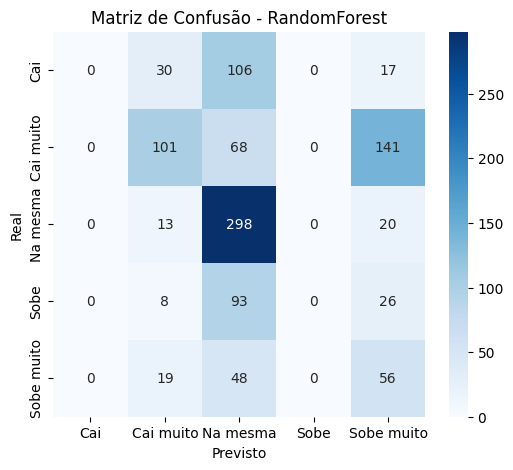

In [6]:
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)
cm_df = pd.DataFrame(cm, index=best_rf.classes_, columns=best_rf.classes_)
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão - RandomForest')
plt.show()

# TESTANDO MODELO

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# best_rf (modelo otimizado) nas funções
clf = best_rf

# Horizons disponíveis na base
rel_horizons = [1, 5, 30, 90]

# Datas testáveis disponíveis
datas_teste = df_long_sorted.loc[X_test.index, 'date'].unique()
unique_dates = sorted([str(d)[:10] for d in datas_teste])

dropdown_data = widgets.Dropdown(
    options=unique_dates,
    value=unique_dates[-1],
    description='Data base:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)
output = widgets.Output()

#  pegar apenas [1,5,30,90] na data escolhida
def previsao_tabela(clf, X, df_reference, y, date, rel_horizons):
    y_pred_proba = clf.predict_proba(X)
    y_pred = clf.predict(X)
    proba_columns = [f'proba_{cls}' for cls in clf.classes_]
    df_proba = pd.DataFrame(y_pred_proba, columns=proba_columns, index=X.index)
    df_pred = X[['horizon']].copy()
    df_pred['date'] = df_reference.loc[X.index, 'date']
    df_pred['target_pred'] = y_pred
    for col in proba_columns:
        df_pred[col] = df_proba[col] * 100
    if y is not None:
        df_pred['target_true'] = y.values
        display_cols = ['date', 'horizon', 'target_true', 'target_pred'] + proba_columns
    else:
        display_cols = ['date', 'horizon', 'target_pred'] + proba_columns
    df_print = df_pred[display_cols]
    # Filtro principal
    df_print = df_print[df_print['date'].astype(str).str.startswith(str(date))]
    df_print = df_print[df_print['horizon'].isin(rel_horizons)]
    df_print = df_print.sort_values('horizon')
    return df_print.reset_index(drop=True)

def show_result():
    with output:
        clear_output()
        data_escolhida = dropdown_data.value
        tab = previsao_tabela(clf, X_test, df_long_sorted, y_test, data_escolhida, rel_horizons)
        print(f"Previsões para data base {data_escolhida}, horizons [1, 5, 30, 90]:\n")
        if not tab.empty:
            display(
                tab[['horizon', 'target_true', 'target_pred'] +
                    [col for col in tab.columns if col.startswith('proba_')]]
                    .style.format({col:"{:.1f}%" for col in tab.columns if col.startswith('proba_')})
                    .set_properties(**{'text-align': 'center'})
                    .set_table_styles([{"selector": "th", "props": [("text-align", "center")]}])
            )
            # Acurácia macro e explicação
            acc_macro = (tab['target_true'] == tab['target_pred']).mean() if not tab.empty else 0
            num_acertos = (tab['target_true'] == tab['target_pred']).sum()
            num_total = len(tab)
            print(f"\n🎯 **Acurácia macro nesta data:** {acc_macro:.2%} (Acertou {num_acertos} de {num_total})")
        else:
            print("Sem previsão para essa data. Escolha outra data base.")

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        show_result()
dropdown_data.observe(on_change)
display(dropdown_data, output)
show_result()


Dropdown(description='Data base:', index=260, layout=Layout(width='50%'), options=('2024-08-21', '2024-08-22',…

Output()

# RANGE DE DATAS PARA TESTAR:

2024-08-21 ATÉ NO MÁXIMO 2025-08-20 (HOJE); Obviamente, se for testar com os dias mais recentes dos dados, não vamos ter como saber se o modelo acertou mesmo. Por isso recomendo 90 dias a menos que 2025-08-20. (2025-05-22)

In [9]:
# Pegue as datas de teste pelo índice no df_long_sorted
datas_teste = df_long_sorted.loc[X_test.index, 'date']

print("MIN:", datas_teste.min())
print("MAX:", datas_teste.max())

# Para ver todas disponíveis:
print(sorted(datas_teste.unique()))


MIN: 2024-08-21 00:00:00
MAX: 2025-08-20 00:00:00
[Timestamp('2024-08-21 00:00:00'), Timestamp('2024-08-22 00:00:00'), Timestamp('2024-08-23 00:00:00'), Timestamp('2024-08-26 00:00:00'), Timestamp('2024-08-27 00:00:00'), Timestamp('2024-08-28 00:00:00'), Timestamp('2024-08-29 00:00:00'), Timestamp('2024-08-30 00:00:00'), Timestamp('2024-09-02 00:00:00'), Timestamp('2024-09-03 00:00:00'), Timestamp('2024-09-04 00:00:00'), Timestamp('2024-09-05 00:00:00'), Timestamp('2024-09-06 00:00:00'), Timestamp('2024-09-09 00:00:00'), Timestamp('2024-09-10 00:00:00'), Timestamp('2024-09-11 00:00:00'), Timestamp('2024-09-12 00:00:00'), Timestamp('2024-09-13 00:00:00'), Timestamp('2024-09-16 00:00:00'), Timestamp('2024-09-17 00:00:00'), Timestamp('2024-09-18 00:00:00'), Timestamp('2024-09-19 00:00:00'), Timestamp('2024-09-20 00:00:00'), Timestamp('2024-09-23 00:00:00'), Timestamp('2024-09-24 00:00:00'), Timestamp('2024-09-25 00:00:00'), Timestamp('2024-09-26 00:00:00'), Timestamp('2024-09-27 00:00:00'

Top 15 features mais importantes:
                        Importância (Gini)
horizon                             0.1511
dxy_min21                           0.0190
dxy                                 0.0184
dxy_lag1                            0.0154
dxy_ma10                            0.0149
dxy_ma21                            0.0144
steel_max21                         0.0141
dxy_min5                            0.0126
dxy_lag3                            0.0126
dxy_max21                           0.0125
dxy_lag5                            0.0115
century_aluminum_min21              0.0110
aluminum_minus_lead                 0.0108
dxy_max5                            0.0107
steel_max5                          0.0106


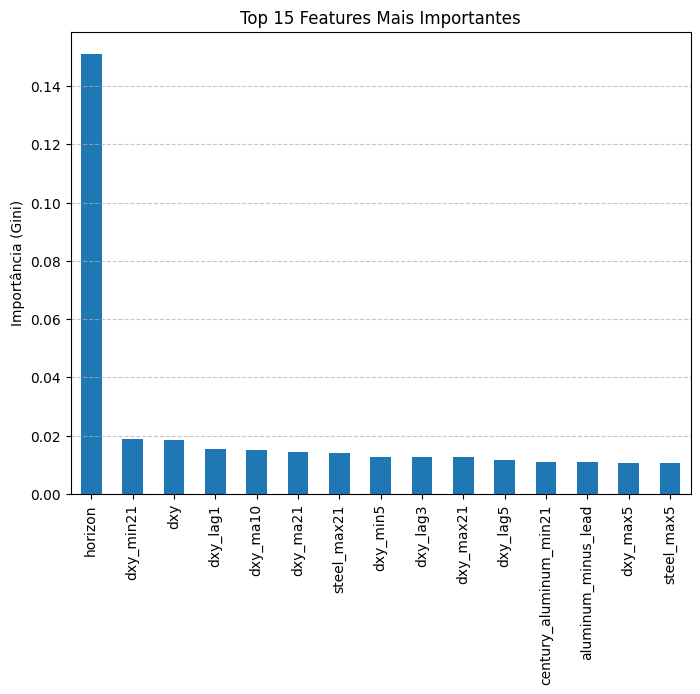

In [11]:
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

# Imprime as 15 features mais importantes com a importância já formatada
print("Top 15 features mais importantes:")
print(importances.head(15).to_frame("Importância (Gini)").round(4))

# Gráfico das 15 principais
plt.figure(figsize=(8, 6))
importances.head(15).plot(kind='bar')
plt.title('Top 15 Features Mais Importantes')
plt.ylabel('Importância (Gini)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


## Desbalanceamento existe, mas não é absurdo

### Modelo único não capta peculiaridades!

### Distribuição de classes é altamente dependente do horizon.

o padrão das classes muda radicalmente de acordo com o prazo analisado. Solução: 1 modelo pra cada

Distribuição geral das classes (todas os horizontes):
target
Na mesma      1494
Sobe muito    1208
Cai muito     1039
Sobe           747
Cai            728
Name: count, dtype: int64

Proporção geral das classes:
target
Na mesma      28.64%
Sobe muito    23.16%
Cai muito     19.92%
Sobe          14.32%
Cai           13.96%
Name: proportion, dtype: object

Distribuição das classes por horizon:
target   Cai  Cai muito  Na mesma  Sobe  Sobe muito
horizon                                            
1        186          9       873   226          10
5        295        110       439   305         155
30       171        383       134   143         473
90        76        537        48    73         570


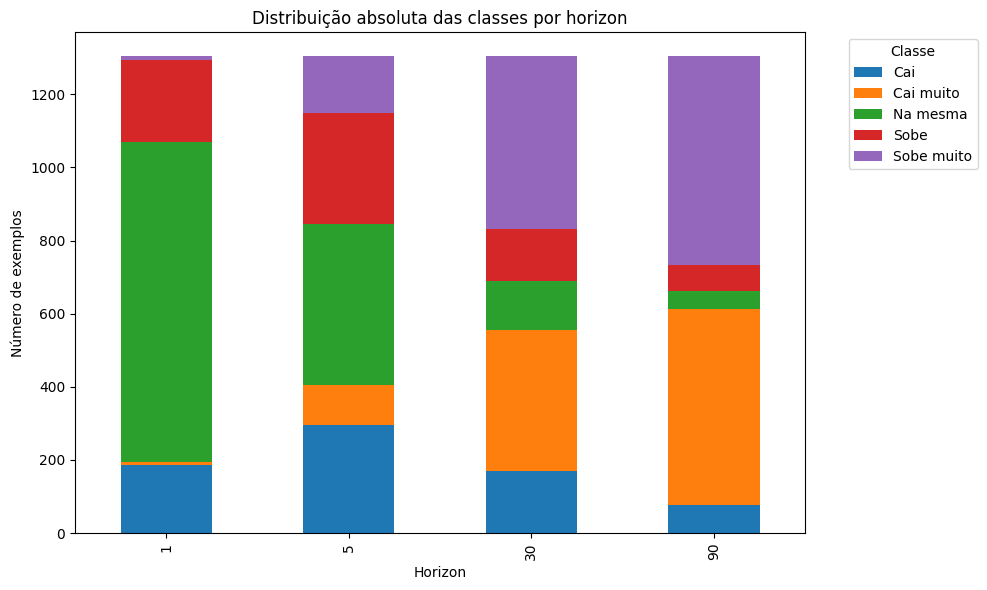

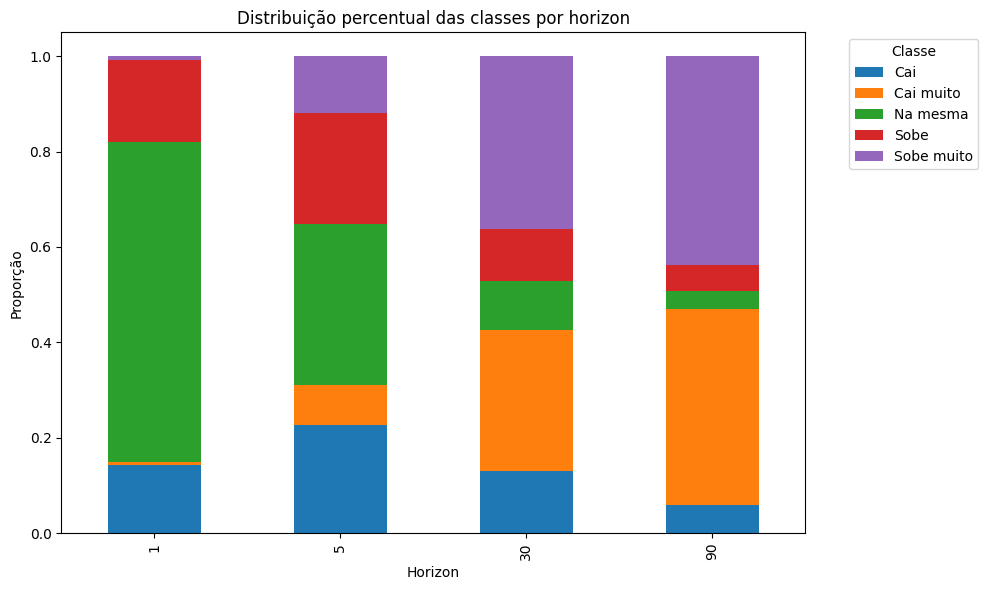

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Garante compatibilidade, e colunas
# (df_long é seu DataFrame principal)

# 1. Value counts geral
print("Distribuição geral das classes (todas os horizontes):")
print(df_long['target'].value_counts())
print("\nProporção geral das classes:")
print((df_long['target'].value_counts(normalize=True) * 100).round(2).astype(str) + '%')

# 2. Value counts por horizon
print("\nDistribuição das classes por horizon:")
counts_per_horizon = df_long.groupby('horizon')['target'].value_counts().unstack().fillna(0)
print(counts_per_horizon.astype(int))

# 3. Gráfico: Classes por horizon (absoluto)
fig, ax = plt.subplots(figsize=(10, 6))
counts_per_horizon.plot(kind='bar', stacked=True, ax=ax)
plt.title("Distribuição absoluta das classes por horizon")
plt.ylabel("Número de exemplos")
plt.xlabel("Horizon")
plt.legend(title="Classe", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4. Gráfico: Classes por horizon (proporcional)
fig, ax = plt.subplots(figsize=(10, 6))
prop_per_horizon = counts_per_horizon.div(counts_per_horizon.sum(axis=1), axis=0)
prop_per_horizon.plot(kind='bar', stacked=True, ax=ax)
plt.title("Distribuição percentual das classes por horizon")
plt.ylabel("Proporção")
plt.xlabel("Horizon")
plt.legend(title="Classe", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Abordagem 1 modelo pra cada: Versão simples antes de refinar.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np

RANDOM_STATE = 42
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2']
}
horizons = [1, 5, 30, 90]   

results_by_horizon = {}
models_by_horizon = {}

for hz in horizons:
    print("="*50)
    print(f">>> HORIZON: {hz} <<<")
    # 1. Filtra para o horizon específico
    df_hz = df_long[df_long['horizon']==hz].sort_values('date').reset_index(drop=True)
    # 2. Split temporal como no modelo global
    unique_dates = df_hz['date'].sort_values().unique()
    split_ix = int(0.8 * len(unique_dates))
    train_dates = unique_dates[:split_ix]
    test_dates = unique_dates[split_ix:]
    X_train = df_hz[df_hz['date'].isin(train_dates)][feature_cols]
    y_train = df_hz[df_hz['date'].isin(train_dates)]['target']
    X_test = df_hz[df_hz['date'].isin(test_dates)][feature_cols]
    y_test = df_hz[df_hz['date'].isin(test_dates)]['target']
    print(f"Treino: X = {X_train.shape}, Teste: X = {X_test.shape}")
    print("Classes treino:", y_train.value_counts().to_dict())
    print("Classes teste:", y_test.value_counts().to_dict())
    
    # 3. Grid search
    rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1)
    clf_grid = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring='accuracy', 
        n_jobs=-1,
        cv=3,
        verbose=2
    )
    clf_grid.fit(X_train, y_train)
    best_rf = clf_grid.best_estimator_
    models_by_horizon[hz] = best_rf
    y_pred = best_rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cl_report = classification_report(y_test, y_pred, output_dict=True)
    # Guarde resultados e métricas-chave
    results_by_horizon[hz] = {
        "best_params": clf_grid.best_params_,
        "train_shape": X_train.shape,
        "test_shape": X_test.shape,
        "accuracy": acc,
        "macro_f1": cl_report["macro avg"]["f1-score"],
        "weighted_f1": cl_report["weighted avg"]["f1-score"],
        "macro_precision": cl_report["macro avg"]["precision"],
        "macro_recall": cl_report["macro avg"]["recall"],
        "confusion_matrix": confusion_matrix(y_test, y_pred, labels=best_rf.classes_),
        "class_report": cl_report
    }
    print(f"Melhores parâmetros: {clf_grid.best_params_}")
    print(f'Acurácia: {acc:.3f}')
    print(classification_report(y_test, y_pred))

# 4. métricas em uma tabela
metrics_df = pd.DataFrame({
    hz: {k: v for k, v in results.items() if not isinstance(v, (np.ndarray, dict))}
    for hz, results in results_by_horizon.items()
}).T
print("Resumo métricas por horizon:")
display(metrics_df)


>>> HORIZON: 1 <<<
Treino: X = (1043, 532), Teste: X = (261, 532)
Classes treino: {'Na mesma': 685, 'Sobe': 186, 'Cai': 156, 'Sobe muito': 9, 'Cai muito': 7}
Classes teste: {'Na mesma': 188, 'Sobe': 40, 'Cai': 30, 'Cai muito': 2, 'Sobe muito': 1}
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

Melhores parâmetros: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 100}
Acurácia: 0.709
              precision    recall  f1-score   support

         Cai       0.17      0.03      0.06        30
   Cai muito       0.00      0.00      0.00         2
    Na mesma       0.73      0.96      0.83       188
        Sobe       0.38      0.07      0.12        40
  Sobe muito       0.00      0.00      0.00         1

    accuracy                           0.71       261
   macro avg       0.25      0.21      0.20       261
weighted avg       0.60      0.71      0.62       261

>>> HORIZON: 5 <<<
Treino: X = (1043, 532), Teste: X = (261, 532)
Classes treino: {'Na mesma': 337, 'Sobe': 255, 'Cai': 233, 'Sobe muito': 130, 'Cai muito': 88}
Classes teste: {'Na mesma': 102, 'Cai': 62, 'Sobe': 50, 'Sobe muito': 25, 'Cai muito': 22}
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

Melhores parâmetros: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 100}
Acurácia: 0.222
              precision    recall  f1-score   support

         Cai       0.24      0.69      0.35        62
   Cai muito       0.00      0.00      0.00        22
    Na mesma       0.00      0.00      0.00       102
        Sobe       0.20      0.24      0.22        50
  Sobe muito       0.18      0.12      0.14        25

    accuracy                           0.22       261
   macro avg       0.12      0.21      0.14       261
weighted avg       0.11      0.22      0.14       261

>>> HORIZON: 30 <<<
Treino: X = (1043, 532), Teste: X = (261, 532)
Classes treino: {'Sobe muito': 406, 'Cai muito': 291, 'Cai': 136, 'Sobe': 108, 'Na mesma': 102}
Classes teste: {'Cai muito': 92, 'Sobe muito': 67, 'Sobe': 35, 'Cai': 35, 'Na mesma': 32}
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

Melhores parâmetros: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 100}
Acurácia: 0.284
              precision    recall  f1-score   support

         Cai       0.00      0.00      0.00        35
   Cai muito       0.42      0.27      0.33        92
    Na mesma       0.00      0.00      0.00        32
        Sobe       0.00      0.00      0.00        35
  Sobe muito       0.24      0.73      0.37        67

    accuracy                           0.28       261
   macro avg       0.13      0.20      0.14       261
weighted avg       0.21      0.28      0.21       261

>>> HORIZON: 90 <<<
Treino: X = (1043, 532), Teste: X = (261, 532)
Classes treino: {'Sobe muito': 540, 'Cai muito': 343, 'Sobe': 71, 'Cai': 50, 'Na mesma': 39}
Classes teste: {'Cai muito': 194, 'Sobe muito': 30, 'Cai': 26, 'Na mesma': 9, 'Sobe': 2}
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Melhores parâmetros: {'max_depth': 20, 'max_features': 'log2', 'min_samples_l

C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

,train_shape,test_shape,accuracy,macro_f1,weighted_f1,macro_precision,macro_recall
1,"(1043, 532)","(261, 532)",0.708812,0.202548,0.62497,0.254892,0.21422
5,"(1043, 532)","(261, 532)",0.222222,0.142306,0.13883,0.121891,0.21071
30,"(1043, 532)","(261, 532)",0.283525,0.138924,0.209821,0.13209,0.200616
90,"(1043, 532)","(261, 532)",0.114943,0.050847,0.029223,0.029126,0.2



🔎 Tabela comparativa (modelo único VS modelo por horizon):

   horizon  unico_accuracy  unico_macro_f1  unico_weighted_f1  \
0        1           0.108           0.048              0.026   
1        5           0.138           0.059              0.041   
2       30           0.092           0.042              0.019   
3       90           0.121           0.053              0.032   

   unico_macro_precision  unico_macro_recall  horiz_accuracy  horiz_macro_f1  \
0                  0.027                 0.2           0.709           0.202   
1                  0.035                 0.2           0.222           0.142   
2                  0.024                 0.2           0.284           0.139   
3                  0.031                 0.2           0.115           0.051   

   horiz_weighted_f1  horiz_macro_precision  horiz_macro_recall  
0              0.625                  0.255               0.214  
1              0.139                  0.122               0.211  
2             

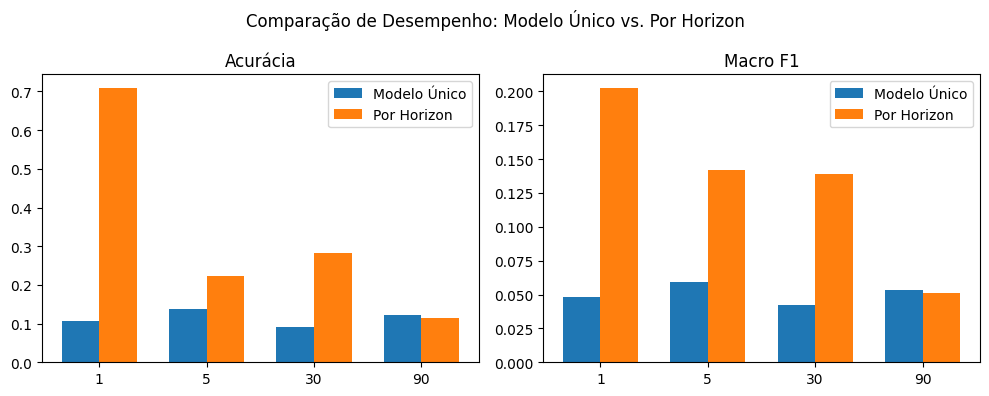

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Horizons de interesse
rel_horizons = [1, 5, 30, 90]

X_test_full = X_test.copy()
X_test_full['horizon'] = df_long_sorted.loc[X_test.index, 'horizon'].values
X_test_full['date'] = df_long_sorted.loc[X_test.index, 'date'].values
y_test_full = y_test.copy()
y_test_full.index = X_test_full.index  # garantir alinhamento dos índices

# Previsões do modelo único
y_pred_full = best_rf.predict(X_test)

def get_metrics(y_true, y_pred):
    result = {}
    result['accuracy'] = accuracy_score(y_true, y_pred)
    result['macro_f1'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    result['weighted_f1'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    result['macro_precision'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    result['macro_recall'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    return result

# dicionário para o modelo único
metrics_unico = {}
for h in rel_horizons:
    idx = X_test_full['horizon'] == h
    met = get_metrics(y_test_full[idx], np.array(y_pred_full)[idx])
    metrics_unico[h] = met

# Resultado modelo único em DataFrame
df_unico = pd.DataFrame(metrics_unico).T.reset_index().rename(columns={'index': 'horizon'})
df_unico.columns = ['horizon', 'unico_accuracy', 'unico_macro_f1', 'unico_weighted_f1',
                    'unico_macro_precision', 'unico_macro_recall']

# Para os MODELOS POR HORIZON
metrics_por_horizon = {
    1:   {'accuracy': 0.7088, 'macro_f1': 0.2025, 'weighted_f1': 0.6250, 'macro_precision': 0.2549, 'macro_recall': 0.2142},
    5:   {'accuracy': 0.2222, 'macro_f1': 0.1423, 'weighted_f1': 0.1388, 'macro_precision': 0.1219, 'macro_recall': 0.2107},
    30:  {'accuracy': 0.2835, 'macro_f1': 0.1389, 'weighted_f1': 0.2098, 'macro_precision': 0.1321, 'macro_recall': 0.2006},
    90:  {'accuracy': 0.1149, 'macro_f1': 0.0508, 'weighted_f1': 0.0292, 'macro_precision': 0.0291, 'macro_recall': 0.2000},
}
df_horiz = pd.DataFrame(metrics_por_horizon).T.reset_index().rename(columns={'index': 'horizon'})
df_horiz.columns = ['horizon', 'horiz_accuracy', 'horiz_macro_f1', 'horiz_weighted_f1',
                    'horiz_macro_precision', 'horiz_macro_recall']

# Junta os dois para comparação clara
df_comp = pd.merge(df_unico, df_horiz, on='horizon')
print("\n🔎 Tabela comparativa (modelo único VS modelo por horizon):\n")
print(df_comp.round(3))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
width = 0.35
x = np.arange(len(rel_horizons))

# Accuracy
ax[0].bar(x - width/2, df_comp['unico_accuracy'], width, label='Modelo Único')
ax[0].bar(x + width/2, df_comp['horiz_accuracy'], width, label='Por Horizon')
ax[0].set_xticks(x)
ax[0].set_xticklabels(rel_horizons)
ax[0].set_title('Acurácia')
ax[0].legend()

# Macro F1
ax[1].bar(x - width/2, df_comp['unico_macro_f1'], width, label='Modelo Único')
ax[1].bar(x + width/2, df_comp['horiz_macro_f1'], width, label='Por Horizon')
ax[1].set_xticks(x)
ax[1].set_xticklabels(rel_horizons)
ax[1].set_title('Macro F1')
ax[1].legend()

plt.suptitle('Comparação de Desempenho: Modelo Único vs. Por Horizon')
plt.tight_layout()
plt.show()

